In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection details
user = 'admin'
password = 'admin'
host = 'localhost\\SQLEXPRESS'
database = 'WideWorldImporters'

# Create the engine
engine = create_engine(
    f'mssql+pyodbc://{user}:{password}@{host}/{database}?'
    'TrustServerCertificate=yes&'
    'driver=ODBC+Driver+17+for+SQL+Server'
)

In [2]:
# Query to get table names and schemas
query = """
    SELECT table_name, table_schema
    FROM information_schema.tables
    WHERE table_type = 'BASE TABLE'
"""

# Load table names into a DataFrame
table_names_df = pd.read_sql(query, engine)
print(table_names_df.head(5))

# Save table names to CSV
table_names_df.to_csv("tables_and_schemas_wwi.csv", index=False)

             table_name table_schema
0                Colors    Warehouse
1        Colors_Archive    Warehouse
2            OrderLines        Sales
3          PackageTypes    Warehouse
4  PackageTypes_Archive    Warehouse


In [3]:
# Extract unique schemas from table names
unique_schemas = table_names_df['table_schema'].unique()

# Create a DataFrame with unique schemas
unique_schemas_df = pd.DataFrame(unique_schemas, columns=['Schema'])

# Print the DataFrame
print(unique_schemas_df)

        Schema
0    Warehouse
1        Sales
2  Application
3   Purchasing


In [4]:
# Load table columns
tables = {}
for index, row in table_names_df.iterrows():
    try:
        tables[f"{row['table_schema']}.{row['table_name']}"] = pd.read_sql(f"SELECT TOP 1 * FROM {row['table_schema']}.{row['table_name']}", engine).columns.tolist()
    except Exception as err:
        print(f"ERROR: {row['table_schema']}.{row['table_name']}")

ERROR: Application.StateProvinces
ERROR: Application.StateProvinces_Archive
ERROR: Application.Cities
ERROR: Application.Cities_Archive
ERROR: Application.SystemParameters
ERROR: Purchasing.Suppliers
ERROR: Purchasing.Suppliers_Archive
ERROR: Sales.Customers
ERROR: Sales.Customers_Archive
ERROR: Application.Countries
ERROR: Application.Countries_Archive


In [5]:
# Infer relationships by matching columns with similar names
relationships = []
#ignored_columns = {"SupplierTransactions", "StockItemTransactions","CustomerTransactions", "LastEditedBy", "ValidTo", "ValidFrom"}
ignored_columns = []
for parent_table, parent_columns in tables.items():
    for child_table, child_columns in tables.items():
        if parent_table != child_table:
            for parent_col in parent_columns:
                if parent_col in ignored_columns:
                    continue  # Skip ignored columns
                for child_col in child_columns:
                    if child_col in ignored_columns:
                        continue  # Skip ignored columns
                    if parent_col == child_col:
                        relationship = {
                            "parent_table": parent_table,
                            "child_table": child_table,
                            "parent_column": parent_col,
                            "child_column": child_col,
                        }
                        relationships.append(relationship)

# Print inferred relationships
for rel in relationships:
    print(f"Parent Table: {rel['parent_table']}, Parent Column: {rel['parent_column']}")
    print(f"Child Table: {rel['child_table']}, Child Column: {rel['child_column']}")
    print("---------")

Parent Table: Warehouse.Colors, Parent Column: ColorID
Child Table: Warehouse.Colors_Archive, Child Column: ColorID
---------
Parent Table: Warehouse.Colors, Parent Column: ColorName
Child Table: Warehouse.Colors_Archive, Child Column: ColorName
---------
Parent Table: Warehouse.Colors, Parent Column: LastEditedBy
Child Table: Warehouse.Colors_Archive, Child Column: LastEditedBy
---------
Parent Table: Warehouse.Colors, Parent Column: ValidFrom
Child Table: Warehouse.Colors_Archive, Child Column: ValidFrom
---------
Parent Table: Warehouse.Colors, Parent Column: ValidTo
Child Table: Warehouse.Colors_Archive, Child Column: ValidTo
---------
Parent Table: Warehouse.Colors, Parent Column: LastEditedBy
Child Table: Sales.OrderLines, Child Column: LastEditedBy
---------
Parent Table: Warehouse.Colors, Parent Column: LastEditedBy
Child Table: Warehouse.PackageTypes, Child Column: LastEditedBy
---------
Parent Table: Warehouse.Colors, Parent Column: ValidFrom
Child Table: Warehouse.PackageTyp

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def generate_node_name(relationships):
    # Initialize a set of stopwords
    stop_words = set(stopwords.words('english'))

    # Collect all words from table names and column names
    words = []
    for rel in relationships:
        words.extend(rel['parent_table'].split('_'))
        words.extend(rel['child_table'].split('_'))
        if rel['parent_column']:
            words.extend(rel['parent_column'].split('_'))
        if rel['child_column']:
            words.extend(rel['child_column'].split('_'))

    # Filter out stopwords and non-alphabetic characters
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    # Count the frequency of each word
    word_freq = {}
    for word in filtered_words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

    # Sort words by frequency in descending order
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # Extract top keywords (1-3 words) for node name
    top_keywords = [word for word, freq in sorted_words[:3]]

    # Join keywords to form node name
    node_name = "_".join(top_keywords)

    return node_name

In [7]:
use_intermedate_nodes = False
if use_intermedate_nodes:
    # Create a dictionary to store the connections of each attribute
    attribute_connections = {}

    # Iterate over the relationships to identify attributes with many connections
    for rel in relationships:
        parent_table = rel['parent_table']
        child_table = rel['child_table']
        parent_column = rel['parent_column']
        child_column = rel['child_column']

        # Update attribute connections for parent column
        if parent_column not in attribute_connections:
            attribute_connections[parent_column] = set()
        attribute_connections[parent_column].add(parent_table)
        attribute_connections[parent_column].add(child_table)

        # Update attribute connections for child column
        if child_column not in attribute_connections:
            attribute_connections[child_column] = set()
        attribute_connections[child_column].add(parent_table)
        attribute_connections[child_column].add(child_table)

    # Identify attributes with many connections
    intermediate_attributes = [attr for attr, connections in attribute_connections.items() if len(connections) > 2]

    # Create a new list of relationships with intermediate nodes
    relationships_with_intermediates = []

    # Create a dictionary to keep track of intermediate nodes and their info
    intermediate_node_info = {}

    # Iterate over the relationships to add intermediate nodes
    for rel in relationships:
        parent_table = rel['parent_table']
        child_table = rel['child_table']
        parent_column = rel['parent_column']
        child_column = rel['child_column']

        # Check if parent column needs an intermediate node
        if parent_column in intermediate_attributes:
            intermediate_node = child_column
            intermediate_node_info[intermediate_node] = [rel]
            relationships_with_intermediates.append({
                "parent_table": parent_table,
                "child_table": intermediate_node,
                "parent_column": parent_column,
                "child_column": intermediate_node  # No specific column for intermediate node
            })
            parent_table = intermediate_node

        # Check if child column needs an intermediate node
        if child_column in intermediate_attributes:
            intermediate_node = parent_column
            if intermediate_node in intermediate_node_info:
                intermediate_node_info[intermediate_node].append(rel)
            else:
                intermediate_node_info[intermediate_node] = [rel]
            relationships_with_intermediates.append({
                "parent_table": intermediate_node,
                "child_table": child_table,
                "parent_column": intermediate_node,  # No specific column for intermediate node
                "child_column": child_column
            })
            child_table = intermediate_node

        # Add the modified relationship
        relationships_with_intermediates.append({
            "parent_table": parent_table,
            "child_table": child_table,
            "parent_column": parent_column,
            "child_column": child_column
        })

    relationships = relationships_with_intermediates

    # Print inferred relationships
    for rel in relationships:
        print(f"Parent Table: {rel['parent_table']}, Parent Column: {rel['parent_column']}")
        print(f"Child Table: {rel['child_table']}, Child Column: {rel['child_column']}")
        print("---------")

Number of nodes: 37
Number of edges: 608
[]


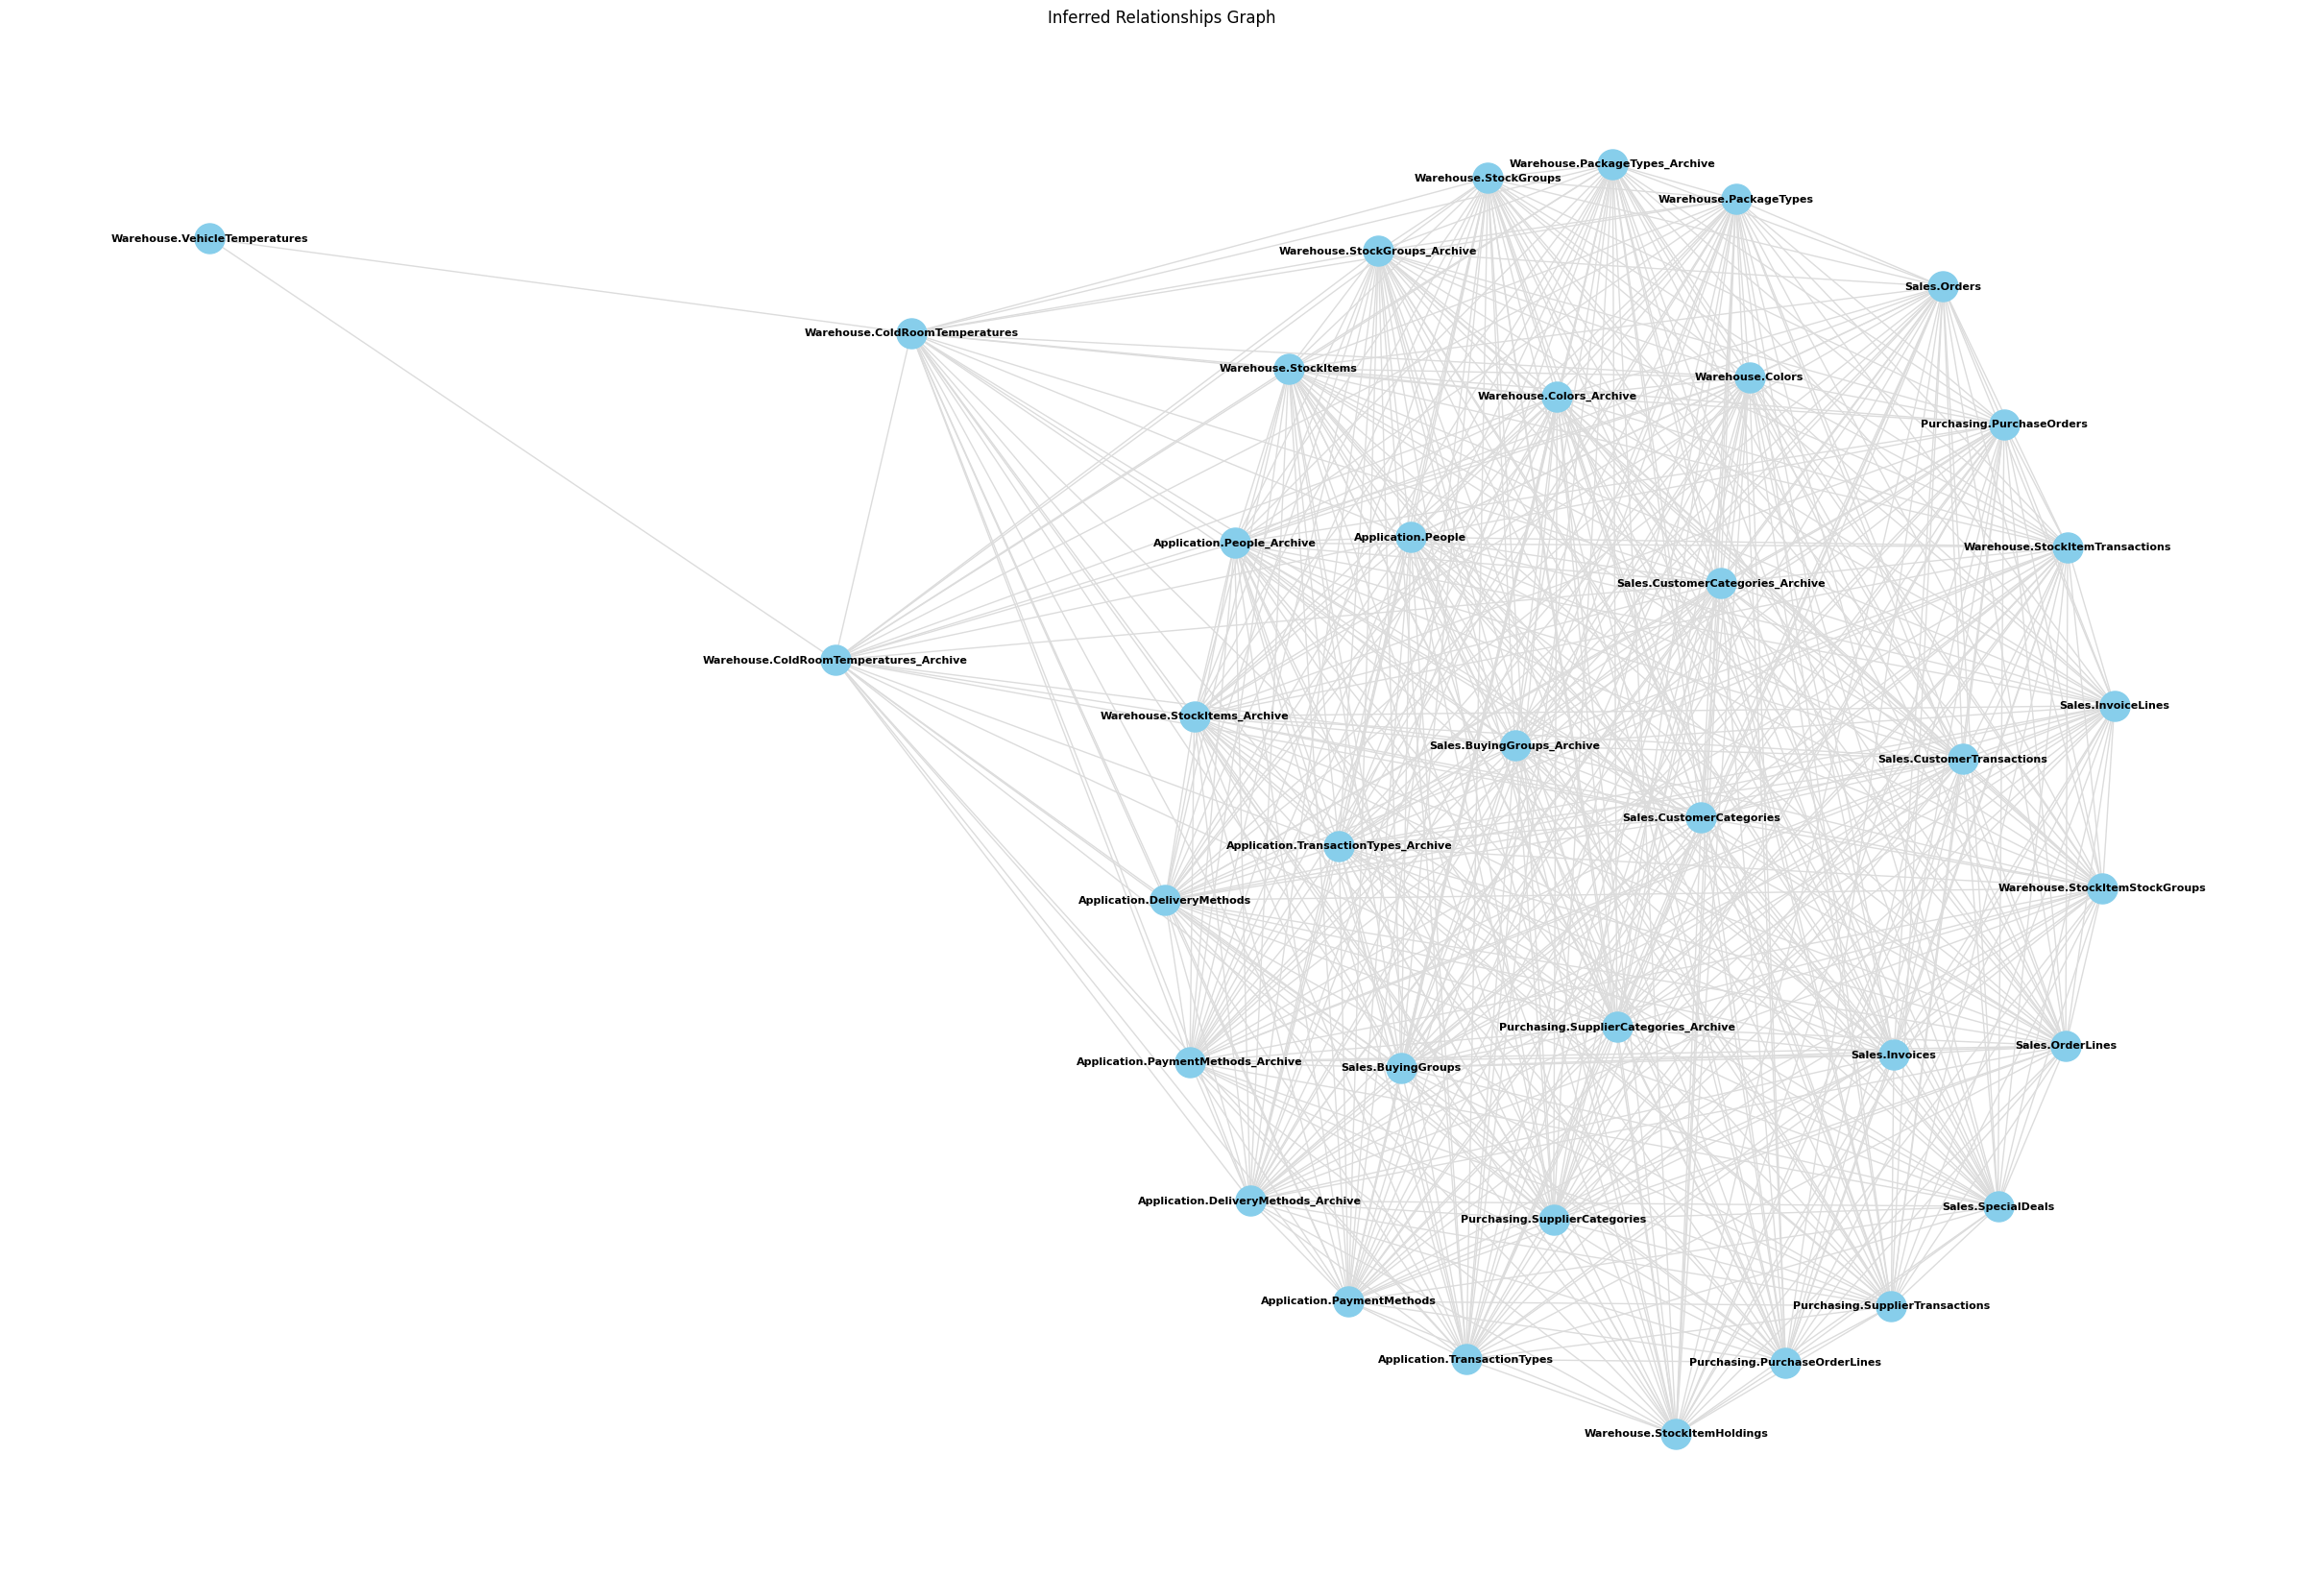

In [8]:
from matplotlib import pyplot as plt
import networkx as nx

# Create a graph
G = nx.DiGraph()

# Add nodes for each table
for table in tables.keys():
    G.add_node(table)

for rel in relationships:
    parent = rel['parent_table']
    child = rel['child_table']
    
    # Ensure that parent and child are not the same
    if parent != child:
        edge_label = f"{rel['parent_column']} -> {rel['child_column']}"
        if G.has_edge(parent, child):
            # If the edge already exists, replace the label
            G[parent][child]['label'] = edge_label
        else:
            G.add_edge(parent, child, label=edge_label)

G = G.to_undirected()

# Count the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

pos = nx.kamada_kawai_layout(G)  # positions for all nodes

# Identify isolated nodes
isolated_nodes = list(nx.isolates(G))
print(isolated_nodes)

plt.figure(figsize=(24, 16))
nx.draw(G, pos, edge_color="gainsboro", with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold')
nx.draw_networkx_nodes(G, pos, nodelist=isolated_nodes, node_color='red', node_size=500)
plt.title("Inferred Relationships Graph")
plt.show()

In [9]:
import pickle

with open('wwi_graph_degree_org.pickle', 'wb') as f:
    pickle.dump(G, f)

In [10]:
import matplotlib.pyplot as plt
from networkx.algorithms import approximation
from networkx.algorithms import community

# Compute eigenvector centrality
node_eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
sorted((f"{c:0.3f}", v) for v, c in node_eigenvector.items())

[('0.007', 'Warehouse.VehicleTemperatures'),
 ('0.115', 'Warehouse.ColdRoomTemperatures'),
 ('0.115', 'Warehouse.ColdRoomTemperatures_Archive'),
 ('0.165', 'Purchasing.PurchaseOrderLines'),
 ('0.165', 'Purchasing.PurchaseOrders'),
 ('0.165', 'Purchasing.SupplierTransactions'),
 ('0.165', 'Sales.CustomerTransactions'),
 ('0.165', 'Sales.InvoiceLines'),
 ('0.165', 'Sales.Invoices'),
 ('0.165', 'Sales.OrderLines'),
 ('0.165', 'Sales.Orders'),
 ('0.165', 'Sales.SpecialDeals'),
 ('0.165', 'Warehouse.StockItemHoldings'),
 ('0.165', 'Warehouse.StockItemStockGroups'),
 ('0.165', 'Warehouse.StockItemTransactions'),
 ('0.172', 'Application.DeliveryMethods'),
 ('0.172', 'Application.DeliveryMethods_Archive'),
 ('0.172', 'Application.PaymentMethods'),
 ('0.172', 'Application.PaymentMethods_Archive'),
 ('0.172', 'Application.People'),
 ('0.172', 'Application.People_Archive'),
 ('0.172', 'Application.TransactionTypes'),
 ('0.172', 'Application.TransactionTypes_Archive'),
 ('0.172', 'Purchasing.Suppl

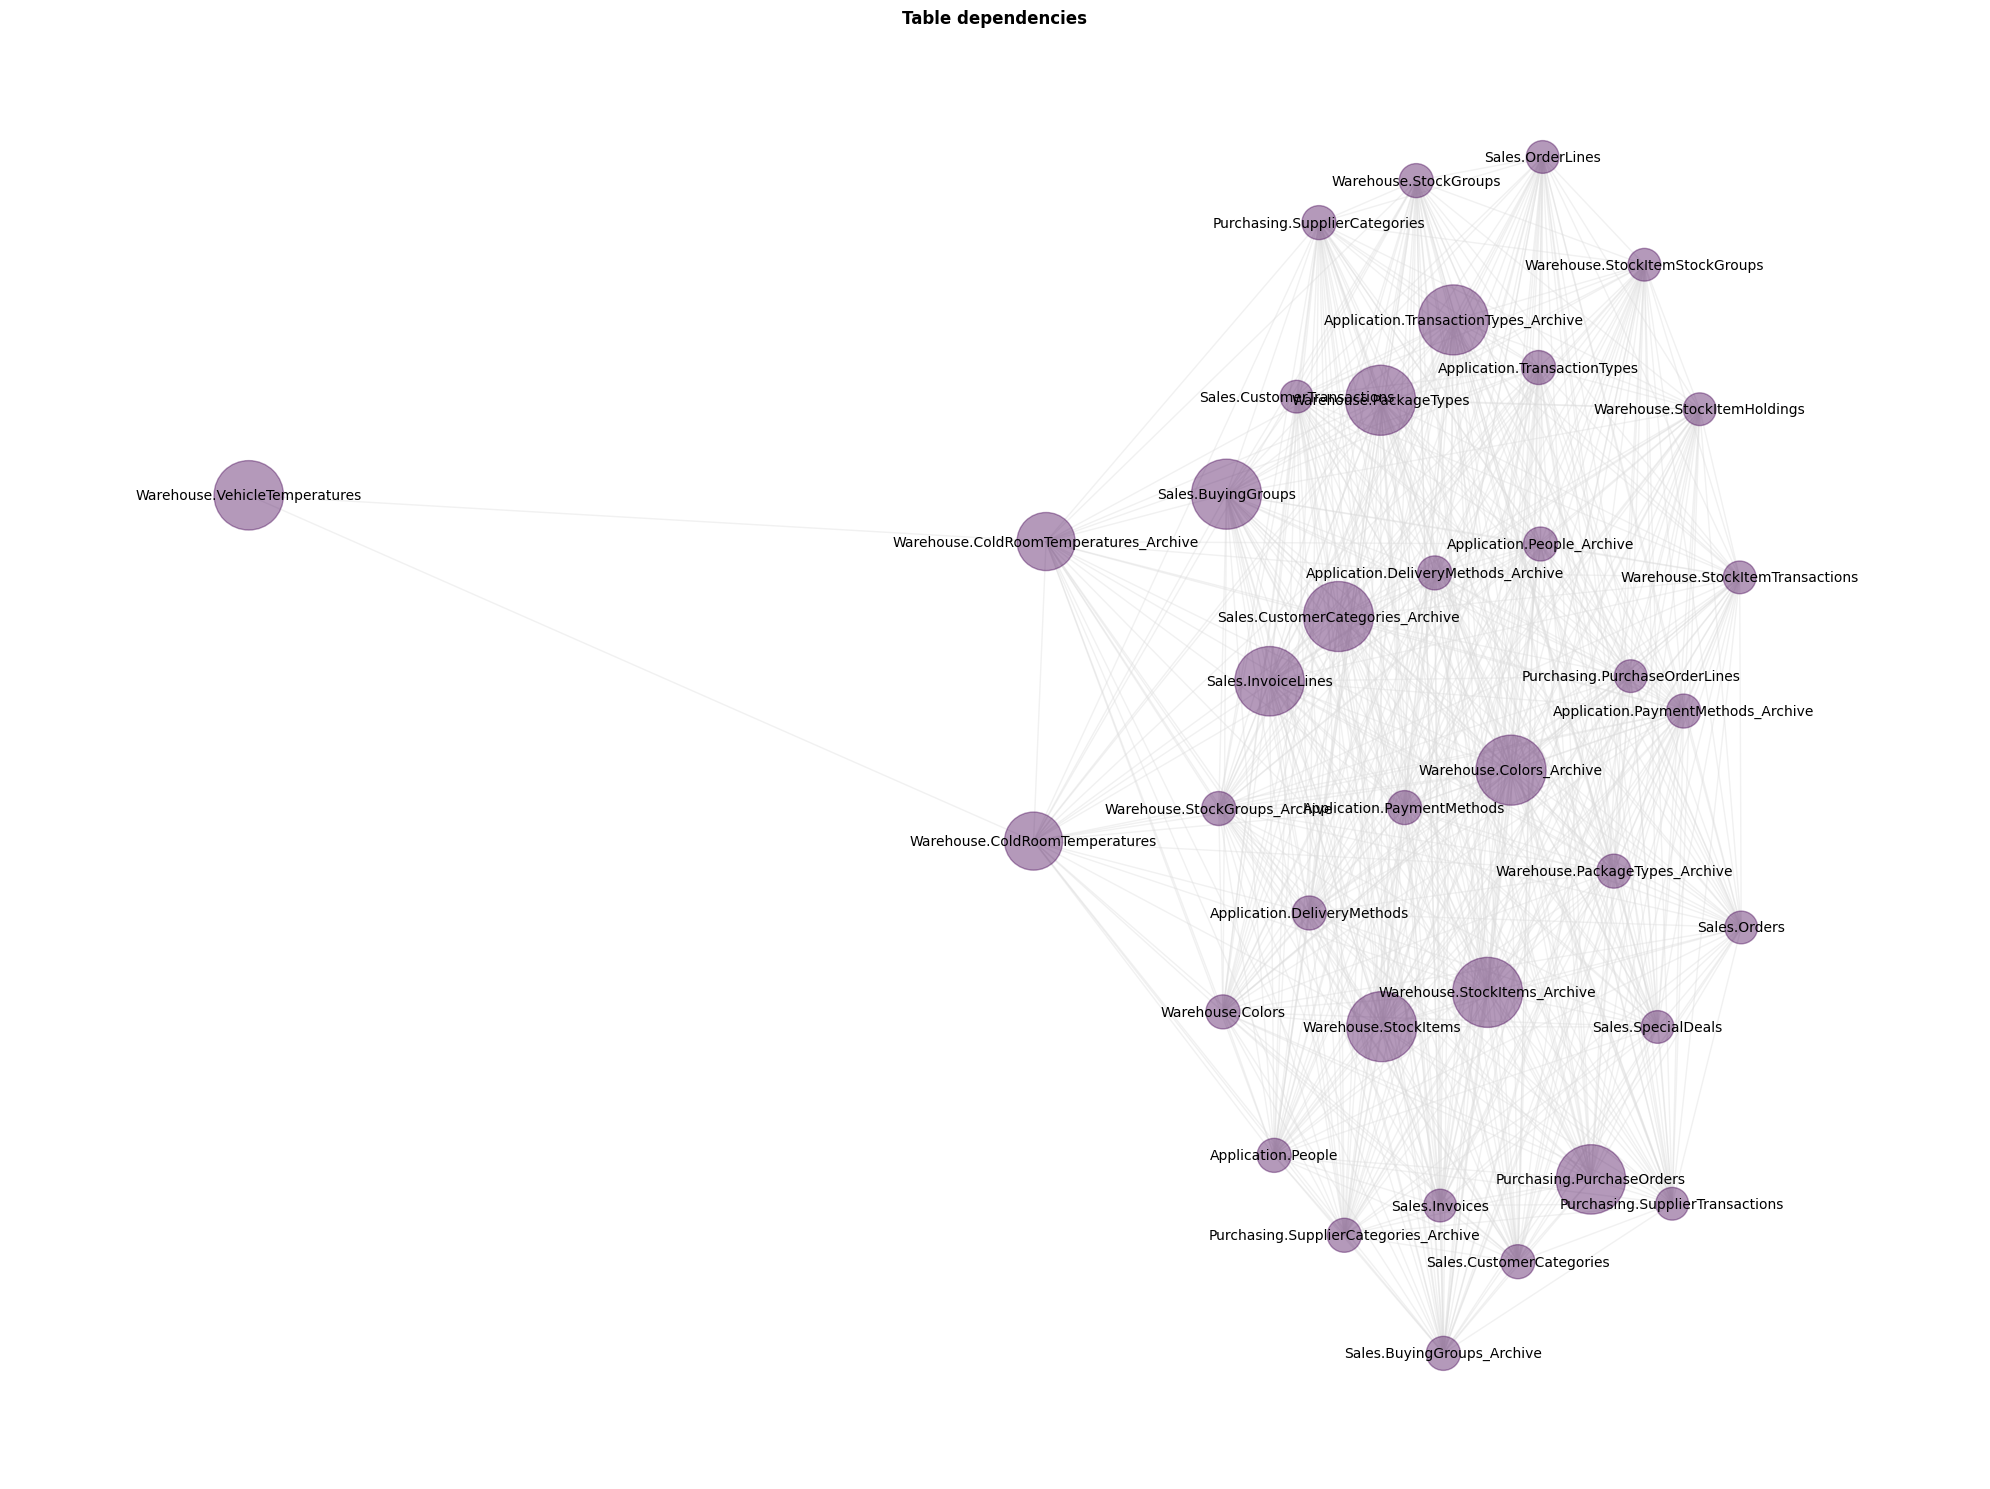

In [11]:
# Largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# Compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# Compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

# Draw graph
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)
nx.draw_networkx_labels(H, pos, font_size=10)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 12}
ax.set_title("Table dependencies", font)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()